# Phone Event2Vec aanpak

## Library imports

In [3]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
from random import randint
import tensorflow as tf
from tensorflow.keras.layers import Dot, Embedding, Flatten
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback
import tqdm.notebook as tq
import io
import matplotlib.pyplot as plt

## Lees de event log dataset uit

In [5]:
eventlog = pd.read_csv("../eventlog/phone_usage_cleaned.csv")
eventlog = eventlog.drop(eventlog.columns[0], 1)
eventlog.head(2)

,Appname,Date,Time,Duration,Timestamp,TimeDiff,Rownumber
0,Screen off (locked),17/05/2019,18:25:07,0:00:02,17/05/2019 18:25:07,3,1
1,Screen on (unlocked),17/05/2019,18:25:10,0:00:01,17/05/2019 18:25:10,0,2


## Clean en Filter de event log

In [6]:
def cleaneventlog(eventlog, undesiredapps):
    eventlog = eventlog.copy()
    eventlog.loc[eventlog.Appname=="à®µà®°à¯ˆà®ªà®Ÿà®®à¯", "Appname"] = "Tamil Nadu Village Map"
    eventlog["Timestamp"] = eventlog["Timestamp"].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))
    eventlog["Seconds"] = eventlog["Timestamp"].apply(lambda x: (x-eventlog["Timestamp"][0]).total_seconds())
    eventlog["Weeks"] =  (eventlog["Seconds"]//(60*60*24*7)).astype(np.int)
    eventlog["Days"] =  (eventlog["Seconds"]//(60*60*24)).astype(np.int)

    origsize=len(eventlog)
    eventlog = eventlog[~eventlog.Appname.isin(undesiredapps)]
    print("undesiredapps reduceerde het aantal events met: " + str(origsize-len(eventlog))
          + "\nvan " + str(origsize) + " naar " + str(len(eventlog)))

    eventlog = eventlog.reset_index(drop=True)

    return eventlog

undesiredapps = ["Screen on (locked)",
                 "Screen off (locked)",
                 "Screen on (unlocked)",
                 "Screen off",
                 "Samsung Experience Service",
                 "Package installer",
                 "System UI",
                 "Customisation Service",
                 "Configuration update",
                 "EmergencyManagerService",
                 "DeviceKeystring",
                 "Samsung Keyboard",
                 "HwModuleTest",
                 "Device shutdown",
                 "Device boot"]
cleanedeventlog = cleaneventlog(eventlog, undesiredapps)

cleanedeventlog.head(2)

undesiredapps reduceerde het aantal events met: 57079
van 90716 naar 33637


,Appname,Date,Time,Duration,Timestamp,TimeDiff,Rownumber,Seconds,Weeks,Days
0,Settings,17/05/2019,18:28:30,0:00:03,2019-05-17 18:28:30,3,5,203.0,0,0
1,Settings,17/05/2019,18:30:17,0:00:03,2019-05-17 18:30:17,3,10,310.0,0,0


## Analyseer de event log

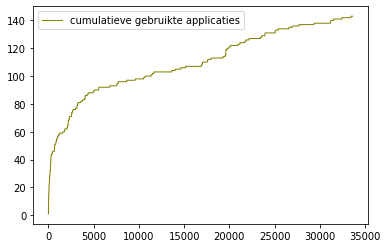

In [9]:
def getnrofapps(appname: str, apps: dict):
    if apps.get(appname) == None:
        apps[appname] = len(apps)
    return len(apps)

apps = {}
cleanedeventlog["Nrusedapps"]= [getnrofapps(appname, apps) for appname in cleanedeventlog.Appname]

data = cleanedeventlog[["Nrusedapps"]]

plt.plot( range(len(data)), 'Nrusedapps', data=data, marker='', color='olive', linewidth=1,
          label="cumulatieve gebruikte applicaties")
plt.legend()
plt.savefig("../outputdata/cumulativeapps.png")
plt.show()

## Event connection graph

In [227]:
import importlib
import sys
from EventConnectionGraph import EventConnectionGraph
importlib.reload(sys.modules['EventConnectionGraph'])
from EventConnectionGraph import EventConnectionGraph

graph = EventConnectionGraph(shape=(200,200),
                             d=900,
                             T=1200)

predictions = []

for index in range(len(cleanedeventlog)-1):
    graph.update(appnames=cleanedeventlog.Appname.iloc[:index+1],
                 apptimes=cleanedeventlog.Seconds.iloc[:index+1])
    predictions.append(graph.predict(apphistory=cleanedeventlog.Appname.iloc[index],
                                     topk=5))

In [228]:
from evaluation import evaluate

cleanedeventlog["Accuracy"] = evaluate(predictions=predictions,
                                       labels=cleanedeventlog.Appname.iloc[1:].to_numpy(),
                                       padfirst=1)

cleanedeventlog.head(2)

,Appname,Date,Time,Duration,Timestamp,TimeDiff,Rownumber,Seconds,Weeks,Days,Nrusedapps,PretrainAccuracy,BigruAccuracy,CombiAccuracy,Accuracy
0,Settings,17/05/2019,18:28:30,0:00:03,2019-05-17 18:28:30,3,5,203.0,0,0,1,False,False,False,False
1,Settings,17/05/2019,18:30:17,0:00:03,2019-05-17 18:30:17,3,10,310.0,0,0,1,False,False,False,True


In [41]:
print(cleanedeventlog.Accuracy.mean())
cleanedeventlog.groupby("Days").Accuracy.mean()

0.7241430567529803


Days
0      0.535088
1      0.670000
2      0.768595
3      0.500000
4      0.694444
         ...   
189    0.756219
190    0.795918
191    0.715447
192    0.771084
193    0.277778
Name: Accuracy, Length: 194, dtype: float64

## Online BiGRU model with graph embedding

In [225]:
importlib.reload(sys.modules['BiGRU'])
from BiGRU import BiGRU
from tensorflow.keras.optimizers import SGD
importlib.reload(sys.modules['EventConnectionGraph'])
from EventConnectionGraph import EventConnectionGraph

graph = EventConnectionGraph(shape=(200,200),
                             d=900,
                             T=1200)
bigru = BiGRU(input_dim=200,
              output_dim=200,
              seq_length=10,
              embedding="onehot")
bigru.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.001),
              metrics=["accuracy"])

for index in range(11):
    graph.update(appnames=cleanedeventlog.Appname.iloc[:index+1],
                 apptimes=cleanedeventlog.Seconds.iloc[:index+1])

predictions = []
for index in tq.tqdm(range(11, len(cleanedeventlog)-1)):
    graph.update(appnames=cleanedeventlog.Appname.iloc[:index+1],
                 apptimes=cleanedeventlog.Seconds.iloc[:index+1])
    bigru.updateembedding(graph.graph)
    history = bigru.livefit(appnames=cleanedeventlog.Appname.iloc[index-11:index])
    predictions.append(bigru.livepredict(appnames=cleanedeventlog.Appname.iloc[index-11:index],
                                         topk=5))

Model: "bi_gru_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 200)           40000     
_________________________________________________________________
bidirectional_110 (Bidirecti (None, 128)               102144    
_________________________________________________________________
dropout_110 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 200)               25800     
Total params: 167,944
Trainable params: 127,944
Non-trainable params: 40,000
_________________________________________________________________
None


  0%|          | 0/33625 [00:00<?, ?it/s]

In [226]:
importlib.reload(sys.modules['evaluation'])
from evaluation import evaluate

cleanedeventlog["CombiAccuracy"] = evaluate(predictions=predictions,
                                       labels=cleanedeventlog.Appname.iloc[12:].to_numpy(),
                                       padfirst=12)

cleanedeventlog.head(2)

,Appname,Date,Time,Duration,Timestamp,TimeDiff,Rownumber,Seconds,Weeks,Days,Nrusedapps,PretrainAccuracy,BigruAccuracy,CombiAccuracy
0,Settings,17/05/2019,18:28:30,0:00:03,2019-05-17 18:28:30,3,5,203.0,0,0,1,False,False,False
1,Settings,17/05/2019,18:30:17,0:00:03,2019-05-17 18:30:17,3,10,310.0,0,0,1,False,False,False


In [49]:
print(cleanedeventlog.CombiAccuracy.mean())
cleanedeventlog.groupby("Days").CombiAccuracy.mean()

0.6556470553259803


Days
0      0.409357
1      0.615000
2      0.636364
3      0.360000
4      0.638889
         ...   
189    0.796020
190    0.755102
191    0.747967
192    0.674699
193    0.222222
Name: CombiAccuracy, Length: 194, dtype: float64

## Online BiGRU model

In [223]:
from BiGRU import BiGRU
importlib.reload(sys.modules['BiGRU'])
from tensorflow.keras.optimizers import SGD
from BiGRU import BiGRU
from tensorflow.keras.optimizers import SGD

numofapps = len(cleanedeventlog.Appname.drop_duplicates())

bigru = BiGRU(input_dim=numofapps,
              output_dim=numofapps,
              seq_length=10,
              embedding="onehot")
bigru.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.001),
              metrics=["accuracy"])

predictions = []
for index in tq.tqdm(range(11, len(cleanedeventlog)-1)):
    history = bigru.livefit(appnames=cleanedeventlog.Appname.iloc[index-11:index])
    predictions.append(bigru.livepredict(appnames=cleanedeventlog.Appname.iloc[index-11:index],
                                         topk=5))

Model: "bi_gru_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 143)           20449     
_________________________________________________________________
bidirectional_109 (Bidirecti (None, 128)               80256     
_________________________________________________________________
dropout_109 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 143)               18447     
Total params: 119,152
Trainable params: 98,703
Non-trainable params: 20,449
_________________________________________________________________
None


  0%|          | 0/33625 [00:00<?, ?it/s]

In [224]:
importlib.reload(sys.modules['evaluation'])
from evaluation import evaluate

cleanedeventlog["BigruAccuracy"] = evaluate(predictions=predictions,
                                       labels=cleanedeventlog.Appname.iloc[12:].to_numpy(),
                                       padfirst=12)

cleanedeventlog.head(2)

,Appname,Date,Time,Duration,Timestamp,TimeDiff,Rownumber,Seconds,Weeks,Days,Nrusedapps,PretrainAccuracy,BigruAccuracy
0,Settings,17/05/2019,18:28:30,0:00:03,2019-05-17 18:28:30,3,5,203.0,0,0,1,False,False
1,Settings,17/05/2019,18:30:17,0:00:03,2019-05-17 18:30:17,3,10,310.0,0,0,1,False,False


In [34]:
print(cleanedeventlog.BigruAccuracy.mean())
cleanedeventlog.groupby("Days").BigruAccuracy.mean()

0.6597496804114517


Days
0      0.356725
1      0.585000
2      0.628099
3      0.320000
4      0.644444
         ...   
189    0.781095
190    0.739796
191    0.756098
192    0.686747
193    0.222222
Name: BigruAccuracy, Length: 194, dtype: float64

## BiGRU from pre trained app embeddings

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, InputLayer
from tensorflow.keras.optimizers import Adam

trainingset = cleanedeventlog[cleanedeventlog.Weeks<2]
numofapps = len(trainingset.Appname.drop_duplicates())

nextapppredictor = Sequential()
nextapppredictor.add(InputLayer(input_shape=(1,)))
nextapppredictor.add(Embedding(input_dim=numofapps,
                               output_dim=4,
                               embeddings_initializer="uniform",
                               trainable=True,
                               mask_zero=False,
                               name="embedding"))
nextapppredictor.add(Dense(numofapps, activation="softmax"))
nextapppredictor.compile(loss='categorical_crossentropy',
                         optimizer=Adam(learning_rate=0.001),
                         metrics=["accuracy"])
nextapppredictor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 4)              256       
_________________________________________________________________
dense (Dense)                (None, 1, 64)             320       
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________


In [6]:
import importlib
import sys
from EventConnectionGraph import EventConnectionGraph
importlib.reload(sys.modules['EventConnectionGraph'])

trainingset = cleanedeventlog[cleanedeventlog.Weeks<2]
numofapps = len(trainingset.Appname.drop_duplicates())

graph = EventConnectionGraph(shape=(numofapps,numofapps),
                             d=900,
                             T=1200)

for index in range(len(trainingset)):
    graph.update(appnames=trainingset.Appname.iloc[:index+1],
                 apptimes=trainingset.Seconds.iloc[:index+1])

In [7]:
def trainnextapppredictor(embedding, nsamples):
    train_x=np.zeros(shape=(nsamples,))
    train_y=np.zeros(shape=(nsamples, 1, len(embedding)))
    for i in range(nsamples):
        prevappindex = np.random.randint(0,len(embedding)-1)
        nextappindex = np.random.choice(len(embedding),p=embedding[prevappindex])
        train_x[i] = prevappindex
        train_y[i, 0, nextappindex] = 1
    batchsize = min(nsamples, 16)
    nextapppredictor.fit(train_x, train_y,
                         batch_size=batchsize, epochs=50, verbose=0)
    nextapppredictor.fit(train_x, train_y,
                         batch_size=batchsize, epochs=1, verbose=1)

embedding = (np.divide(graph.graph.T, graph.graph.sum(axis=1), where=graph.graph.sum(axis=1)!=0)).T
trainnextapppredictor(embedding, 100000)

6250/6250 [==============================] - 2s 374us/step - loss: 2.1764 - accuracy: 0.3296

In [8]:
print(nextapppredictor.predict([51])[0][0].argsort()[-5:][::-1])
print(graph.graph[51].argsort()[-5:][::-1])

[ 0 10 25  6 23]
[ 0 10 16 29 28]


In [42]:
from BiGRU import BiGRU
importlib.reload(sys.modules['BiGRU'])
from BiGRU import BiGRU

embedding = nextapppredictor.get_layer("embedding").get_weights()[0]
padding = np.zeros(shape=(136, embedding.shape[1]), dtype=np.float32)
paddedembedding = np.vstack((embedding, padding))
numofapps = len(cleanedeventlog.Appname.drop_duplicates())

bigru = BiGRU(input_dim=paddedembedding.shape[0],
              output_dim=paddedembedding.shape[1],
              seq_length=10,
              embedding=paddedembedding,
              amntgru=64)
bigru.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=["accuracy"])

trainingset = cleanedeventlog[cleanedeventlog.Weeks<2]
bigru.pretrain(trainingset=trainingset, ttsplit=0.80, epochs=8)
bigru.get_layer("embedding").trainable = True

Model: "bi_gru_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 4)             800       
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               26880     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               25800     
Total params: 53,480
Trainable params: 52,680
Non-trainable params: 800
_________________________________________________________________
None


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [43]:
from evaluation import evaluate
importlib.reload(sys.modules['evaluation'])
from evaluation import evaluate

train_x = np.zeros(shape=(len(trainingset)-10, 10))
train_y = np.zeros(shape=(len(trainingset)-10,))
eventdict = {}
appnamedict = {}
for i in range(10, len(trainingset)):
    currappname = trainingset.Appname.iloc[i]
    if (eventdict.get(currappname) == None):
        if (len(eventdict) == 0):
            for prevappname in trainingset.Appname.iloc[:i]:
                if (eventdict.get(prevappname) == None):
                    newappindex = len(eventdict)
                    eventdict[prevappname] = newappindex
                    appnamedict[newappindex] = prevappname
        currappindex = len(eventdict)
        eventdict[currappname] = currappindex
        appnamedict[currappindex] = currappname

    train_x[i-10,:] = [eventdict.get(appname) for appname in trainingset.Appname.iloc[i-10:i]]
    train_y[i-10,] = eventdict.get(trainingset.Appname.iloc[i])

topk=5
predictions = bigru.predict(train_x, verbose=0)
accurate = []
for i in range(len(predictions)):
    accurate.append(train_y[i] in (-predictions[i]).argsort()[:topk])

print(sum(accurate)/len(accurate))
print(sum(accurate[:int(0.8*len(accurate))])/len(accurate[:int(0.8*len(accurate))]))
print(sum(accurate[int(0.8*len(accurate)):])/len(accurate[int(0.8*len(accurate)):]))

0.7502383222116301
0.7753277711561383
0.65


In [44]:
from BiGRU import BiGRU
importlib.reload(sys.modules['BiGRU'])
from BiGRU import BiGRU
from tensorflow.keras.optimizers import SGD

bigru.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.001),
              metrics=["accuracy"])

livetrainingset = cleanedeventlog[cleanedeventlog.Weeks>1]

predictions = []
for index in tq.tqdm(range(11, len(livetrainingset)-1)):
    bigru.livefitupdateembedding(appnames=livetrainingset.Appname.iloc[index-11:index])
    predictions.append(bigru.livepredict(appnames=livetrainingset.Appname.iloc[index-11:index],
                                         topk=5))

  0%|          | 0/31517 [00:00<?, ?it/s]

In [45]:
importlib.reload(sys.modules['evaluation'])
from evaluation import evaluate

cleanedeventlog["PretrainAccuracy"] = evaluate(predictions=predictions,
                                       labels=livetrainingset.Appname.iloc[12:].to_numpy(),
                                       padfirst=len(trainingset)+12)

cleanedeventlog.head(2)

,Unnamed: 0,Appname,Date,Time,Duration,Timestamp,TimeDiff,Rownumber,Seconds,Weeks,Days,Nrusedapps,PretrainAccuracy,BigruAccuracy,CombiAccuracy,Accuracy
0,0,Settings,17/05/2019,18:28:30,0:00:03,2019-05-17 18:28:30,3,5,203.0,0,0,1,False,False,False,False
1,1,Settings,17/05/2019,18:30:17,0:00:03,2019-05-17 18:30:17,3,10,310.0,0,0,1,False,False,False,True


## Save csv

In [229]:
cleanedeventlog.to_csv("outputdata/accuracy.csv")

In [5]:
cleanedeventlog = pd.read_csv("../outputdata/accuracy.csv")
cleanedeventlog.head(2)

,Unnamed: 0,Appname,Date,Time,Duration,Timestamp,TimeDiff,Rownumber,Seconds,Weeks,Days,Nrusedapps,PretrainAccuracy,BigruAccuracy,CombiAccuracy,Accuracy
0,0,Settings,17/05/2019,18:28:30,0:00:03,2019-05-17 18:28:30,3,5,203.0,0,0,1,False,False,False,False
1,1,Settings,17/05/2019,18:30:17,0:00:03,2019-05-17 18:30:17,3,10,310.0,0,0,1,False,False,False,True


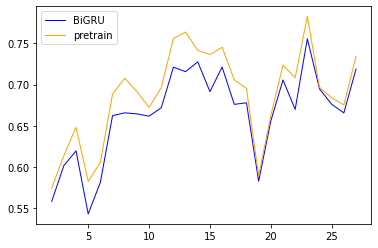

In [7]:
data = cleanedeventlog.groupby("Weeks")[["Accuracy",
                                         "BigruAccuracy",
                                         "CombiAccuracy",
                                         "PretrainAccuracy"]].mean().reset_index()
data = data[data.Weeks>1]

# plt.plot( 'Weeks', 'Accuracy', data=data, marker='', color='olive', linewidth=1,
#           label="graphpred")
plt.plot( 'Weeks', 'BigruAccuracy', data=data, marker='', color='blue', linewidth=1,
          label="BiGRU")
# plt.plot( 'Weeks', 'CombiAccuracy', data=data, marker='', color='red', linewidth=1,
#           label="combi")
plt.plot( 'Weeks', 'PretrainAccuracy', data=data, marker='', color='orange', linewidth=1,
          label="pretrain")
plt.legend()
plt.savefig("../outputdata/liveaccuracy.png")
plt.show()
